In [226]:
import pandas as pd
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk.corpus import webtext
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import operator
from nltk.corpus import stopwords
from random import shuffle
import numpy as np
import random
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn import metrics
from sklearn.metrics import silhouette_score

### Data exploration

In [180]:
taylor_df = pd.read_csv('taylor_swift_lyrics.csv')
beyonce_df = pd.read_csv('beyonce_lyrics.csv')
ed_df = pd.read_csv('EdSheeran.csv')

In [181]:
taylor_df.columns

Index(['Artist ', 'Album', 'Title ', 'Lyrics'], dtype='object')

In [182]:
pd.unique(taylor_df['Album'])

array(['Taylor Swift ', 'Fearless', 'Speak Now ', 'Red', '1989',
       'reputation ', 'Lover ', 'folklore '], dtype=object)

In [183]:
beyonce_df.columns

Index(['line', 'song_id', 'song_name', 'artist_id', 'artist_name',
       'song_line'],
      dtype='object')

In [184]:
taylor_df.head(2)

,Artist,Album,Title,Lyrics
0,Taylor Swift,Taylor Swift,Tim McGraw,He said the way my blue eyes shinx\nPut those ...
1,Taylor Swift,Taylor Swift,Picture to Burn,"State the obvious, I didn't get my perfect fan..."


In [185]:
beyonce_df.head(2)

,line,song_id,song_name,artist_id,artist_name,song_line
0,"If I ain't got nothing, I got you",50396,1+1,498,Beyoncé,1
1,"If I ain't got something, I don't give a damn",50396,1+1,498,Beyoncé,2


In [186]:
def clean_up_lyrics(df, stop_words=False):
    # remove punctuation
    df['Lyrics'] = df['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
    # remove \n
    df['Lyrics'] = df['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
    # turn upper case to lower case
    df['Lyrics'] = df['Lyrics'].map(lambda x: x.lower())
    # remove some other words that don't have actual meanings
    remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 
                'never', 'cause', 'like', 'back', 'just', 'come', 'got',
                't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'think', 'goes', 'new', 'got', 
                'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'knew', 'didn', 'wanna', 'know', 'would', 'could']    
    if stop_words:
        stop_words = stopwords.words('english')
        all_words_to_remove = remove_words + stop_words
        #print(all_words_to_remove)
    else:
        all_words_to_remove = remove_words
    pat = r'\b(?:{})\b'.format('|'.join(all_words_to_remove))
    df['Lyrics'] = df['Lyrics'].str.replace(pat, '') 
    return df

In [187]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

### Top words per album

In [188]:
def find_top_words(taylor_df, top_num_words):
    cv = CountVectorizer()
    songs = taylor_df[['Lyrics','Album']]
    names_album = pd.unique(taylor_df['Album'])
    for i in names_album:
        song_filtered = songs.loc[songs['Album'] == i]
        song_clean = clean_up_lyrics(song_filtered, stop_words=True)
        long_str = song_clean['Lyrics'].values.tolist()
        cv_fit=cv.fit_transform(long_str) 
        word_list = cv.get_feature_names()
        count_list = cv_fit.toarray().sum(axis=0)
        word_freq_dict = dict(zip(word_list,count_list))
        sorted_dict = dict(sorted(word_freq_dict.items(), key=operator.itemgetter(1),reverse=True))
        n_items = take(top_num_words, sorted_dict.items())
        print(i)
        print(n_items)
    

find_top_words(taylor_df, 15)

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Taylor Swift 
[('love', 20), ('one', 18), ('see', 18), ('beautiful', 17), ('baby', 15), ('song', 15), ('way', 15), ('take', 14), ('hope', 13), ('still', 13), ('everything', 12), ('let', 12), ('eyes', 11), ('first', 11), ('break', 10)]
Fearless
[('feel', 27), ('see', 26), ('baby', 25), ('one', 24), ('love', 23), ('way', 23), ('fall', 22), ('help', 20), ('tell', 20), ('night', 18), ('little', 16), ('sorry', 16), ('jump', 15), ('take', 15), ('around', 14)]
Speak Now 
[('ever', 35), ('go', 33), ('see', 32), ('around', 23), ('love', 23), ('away', 22), ('mean', 22), ('still', 22), ('mind', 21), ('grow', 20), ('meet', 17), ('thought', 17), ('right', 16), ('fly', 15), ('gone', 15)]
Red
[('red', 46), ('ever', 35), ('one', 34), ('last', 32), ('stay', 32), ('trouble', 32), ('asking', 25), ('everybody', 25), ('home', 25), ('better', 24), ('love', 24), ('tell', 23), ('starlight', 22), ('look', 21), ('everything', 19)]
1989
[('wish', 85), ('love', 84), ('shake', 70), ('yet', 65), ('baby', 41), ('go'

Based on what I have found on Reddit, Taylor Swift's albums have relatively different themes. 
* Taylor Swift is about exploring identity through the lens of your relationships with others.
* Fearless is about celebrating adolescence.
* Speak Now is about reaching out to people you wish you'd said things to before.
* RED is about how poor communication kills relationships.
* 1989 is about reinvention and smiling through the pain.
* reputation is about falling in love during the chaos.
* Lover is about working at relationships, even when (especially when) they're hard.
* folklore is about grappling with unresolved issues.

By looking at the frequencies of words in each album, we could also think of song of Taylor Swift's songs. 

See some examples below: 

* "Fearless" --> sorry(You're not sorry); tell(tell me why)
* "Speak now" --> mean(Mean); grow(never grow up)
* "red" --> red(red); everything(everything has changed); starlight(starlight); trobule(I knew you were trouble); stay(stay); home(girls at home)
* 1989 --> shake(shake it off); york(welcome to new york); wonderland(wonderland); woods(out of the woods); clear(out of the woods); girl(how you get the girl); good(I wish you would); hate(shake it off); wish(I wish you would)
* reputation --> car(getaway car); dancing(dancing with our hands tied)
* Lover --> one(paper ring); see(Day light; The Archer); daylight(Daylight); right(The Archer); man(The Man); still(False God); Need(You need to calm down); walk(Cornelia street); bad(the heart break prince)
* Folklore --> gave(exile); see(august); mad(mad women); hope(august); mine(august); woman(mad woman)


### Observations:
* We could see the words such as "love", "know", "wanna", "never", "cause", "everything", "see" appear in multiple albums. Let's consider removing them before topic modellling because those words might not be able to clearly distinguish different topics. 

### use a word cloud to get a visual representation of common words in Taylor swift's songs

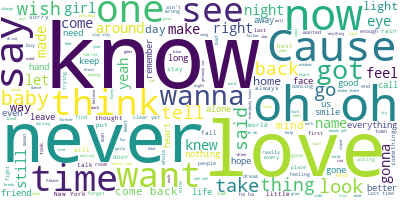

In [189]:
# Join the different processed titles together.
long_string = ','.join(list(taylor_df['Lyrics'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

From the word cloud above, we could see the most common words are: love, know, now, say, ect..

## Topic modelling

In [190]:
lyrics_taylor = taylor_df[['Lyrics']]

In [191]:
# remove punctuation
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# remove \n
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
# turn upper case to lower case
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: x.lower())
# remove some other words that don't have actual meanings
# and also based on my reflection
remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'know', 'wanna',
                'never', 'cause', 'like', 'back', 'love', 'just', 'come', 'got', 'baby', 'would', 'could','na', 'need',
                'think', 'goes', 'new', 'got', 'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'knew', 'didn']
pat = r'\b(?:{})\b'.format('|'.join(remove_words))
# lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].str.replace(pat, '')


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [192]:
lyrics_taylor.head(2)

,Lyrics
0,he the way my blue eyes shinx put those georg...
1,state the obvious i ' get my perfect fantasy i...


In [193]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 8

In [210]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    
    plt.style.use("fivethirtyeight")
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


## NMF

NMF : Latent Semantic Analysis with Non-Negative Matrix Factorization — a way of decomposing the document-term matrix into two smaller matrices that contain only positive values which allows direct interpretation of each matrix as unnormalized probabilities.

In [211]:
# randomly select 60% of data
long_lst = lyrics_taylor['Lyrics'].values.tolist()

def random_select_from_lst(lst, pert):
    k_num = int(len(lst) * pert)
    sample_list = random.choices(lst, k=k_num)
    return sample_list

In [212]:
sample_list = random_select_from_lst(long_lst, 0.6)

In [213]:
print(len(sample_list))

79


In [214]:
# def shuffle_matrix(matrix):
#     indices = np.arange(matrix.shape[0]) #gets the number of rows 
#     shuffle(indices)
#     shuffled_matrix = matrix[list(indices)]
#     return shuffled_matrix

In [215]:
# tfidf = shuffle_matrix(matrix)

In [216]:
long_lst = lyrics_taylor['Lyrics'].values.tolist()

tfidf_vectorizer = TfidfVectorizer(max_features=500,stop_words="english") # we set the max_features to 500, which means that we only consider the top 500 words based on their frequencies 
tfidf = tfidf_vectorizer.fit_transform(long_lst)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
topics = 8

# Run NMF
nmf = NMF(n_components=topics, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
# alpha: float, default=0.0
# Constant that multiplies the regularization terms. Set it to zero to have no regularization. When using alpha instead of alpha_W and alpha_H, the regularization terms are not scaled by the n_features (resp. n_samples) factors for W (resp. H).

#l1_ratio float, default=0.0
#The regularization mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.

In [217]:
tfidf_feature_names

['actress',
 'afraid',
 'ain',
 'alright',
 'american',
 'anymore',
 'apart',
 'arms',
 'ask',
 'asking',
 'away',
 'babe',
 'bad',
 'bar',
 'battle',
 'beat',
 'beautiful',
 'bed',
 'believe',
 'believed',
 'belong',
 'best',
 'bet',
 'better',
 'big',
 'black',
 'blame',
 'bless',
 'blind',
 'blood',
 'blue',
 'body',
 'bought',
 'bout',
 'boy',
 'boys',
 'break',
 'breath',
 'breathe',
 'bright',
 'bring',
 'broke',
 'broken',
 'brought',
 'burned',
 'burning',
 'busy',
 'called',
 'calm',
 'car',
 'care',
 'catch',
 'caught',
 'chance',
 'change',
 'changed',
 'cheeks',
 'city',
 'clean',
 'clear',
 'close',
 'cold',
 'comes',
 'comin',
 'coming',
 'conversation',
 'cool',
 'cornelia',
 'couldn',
 'crazy',
 'cried',
 'cruel',
 'crying',
 'cut',
 'cuts',
 'dance',
 'dancing',
 'dark',
 'darling',
 'day',
 'daydream',
 'daylight',
 'days',
 'dead',
 'dear',
 'death',
 'december',
 'deep',
 'delicate',
 'doesn',
 'doin',
 'doing',
 'door',
 'dream',
 'dreams',
 'dress',
 'dressed',
 '

In [218]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
way right away remember little night day need
Topic 1:
stay mad right easy hold grow loving darling
Topic 2:
beautiful magic sad little taking help looked invisible
Topic 3:
better soon changed mind people actress won make
Topic 4:
bad blood really heartbreak good look stupid win
Topic 5:
trying wanted half hard maybe lot fly quite
Topic 6:
girl everybody works look home wait style worse
Topic 7:
sorry breathe easy movie clean anymore hurt save


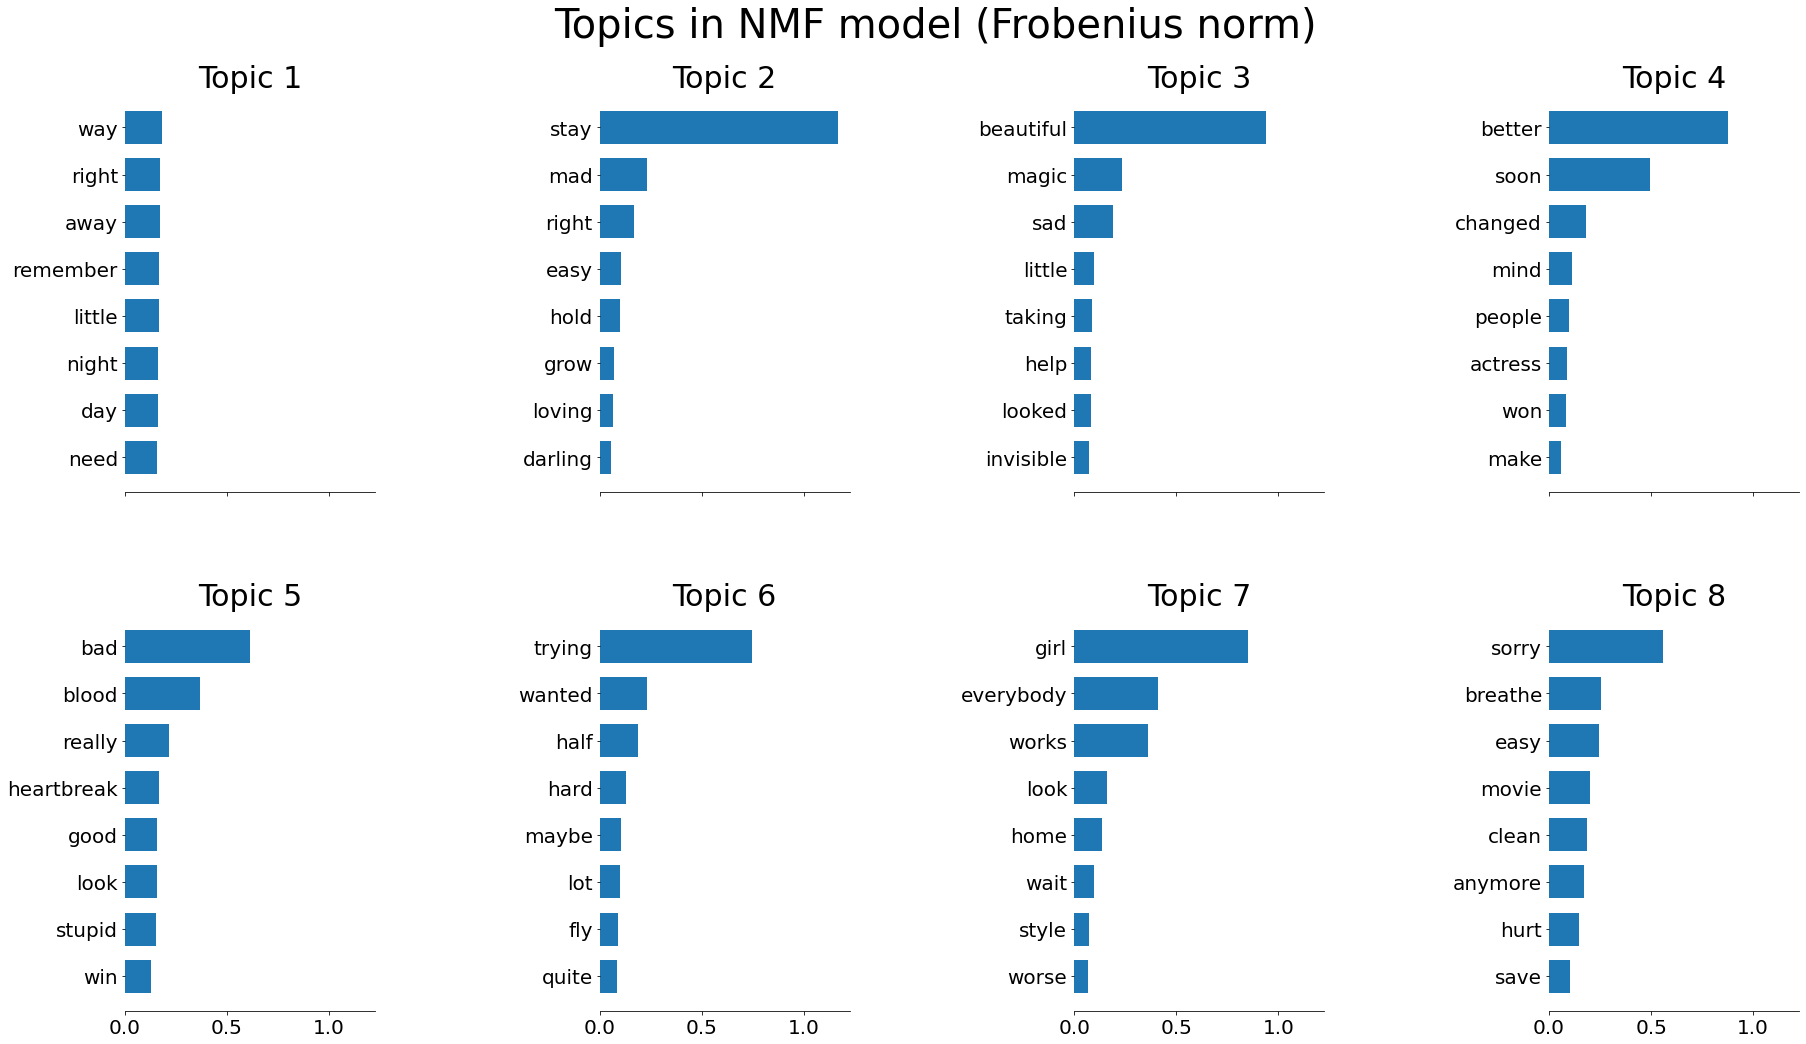

In [219]:
plot_top_words(
    nmf, tfidf_feature_names, no_top_words, "Topics in NMF model (Frobenius norm)"
)

#### Analysis of each topic: 
* Topic 1: tell, look, way (Look like "Nothing new" from Red)
* Topic 2: stay, mad ("stay, stay, stay" from Red)
* Topic 3: beautiful, magic, sad ("sad beautiful tragic" from Red)
* Topic 4: better, changed, mind ("everything has changed" from Red)
* Topic 5: dancing, tied, dance, hands ("dancing with our friends tied" from reputation)
* Topic 6: hope, plans, remember ("august" from Folklore) 
* Topic 7: girl, everybody ("Girl at home" from Red)
* Topic 8: nice, friend, things ("It's nice to have a friend" from Lover)

#### Analysis of each topic: 
* Topic 1: nice, things, darling, wouldn, hear, friends, break, honey (from "This is why we can't have nice things" in Reputation)
* Topic 2: cornelia, walk, street (from "Cornelia street" in Lover)
* Topic 3: young, assume, cardigan, felt, bed (from "Cardigan" in Folklore)
* Topic 4: look, blood, bad (from "bad blood" in 1989)
* Topic 5: girl, trying, strong, wrong, world (from "a place in this world" in Taylor Swift)
* Topic 6: rains, forever, feel, bedroom (from "Forever and always" in Fearless)
* Topic 7: innocent, wasn, string, bright (from "Innocent" in Speak Now)
* Topic 8: careful, careless, daughter (from "Mine" in Speak Now)

### LDA

In [204]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_features=500, stop_words='english')
tf = tf_vectorizer.fit_transform(long_lst)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
# max_iter: The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method
# learning offset: A (positive) parameter that downweights early iterations in online learning. It should be greater than 1.0. In the literature, this is called tau_0.
lda = LatentDirichletAllocation(n_components=topics,learning_method='online', learning_offset=50).fit(tf)


display_topics(lda, tf_feature_names, no_top_words)



Topic 0:
trouble waiting car getaway dress ain delicate right
Topic 1:
peace people heart friend gone long friends talk
Topic 2:
shake look york welcome hate play break fake
Topic 3:
world blue apart pulled screaming stood believe reason
Topic 4:
clear woods good beautiful away mean little big
Topic 5:
watch fall things stay dream make seen speak
Topic 6:
man better way let feel mad look eyes
Topic 7:
thing showed party miss garden summer tell worst


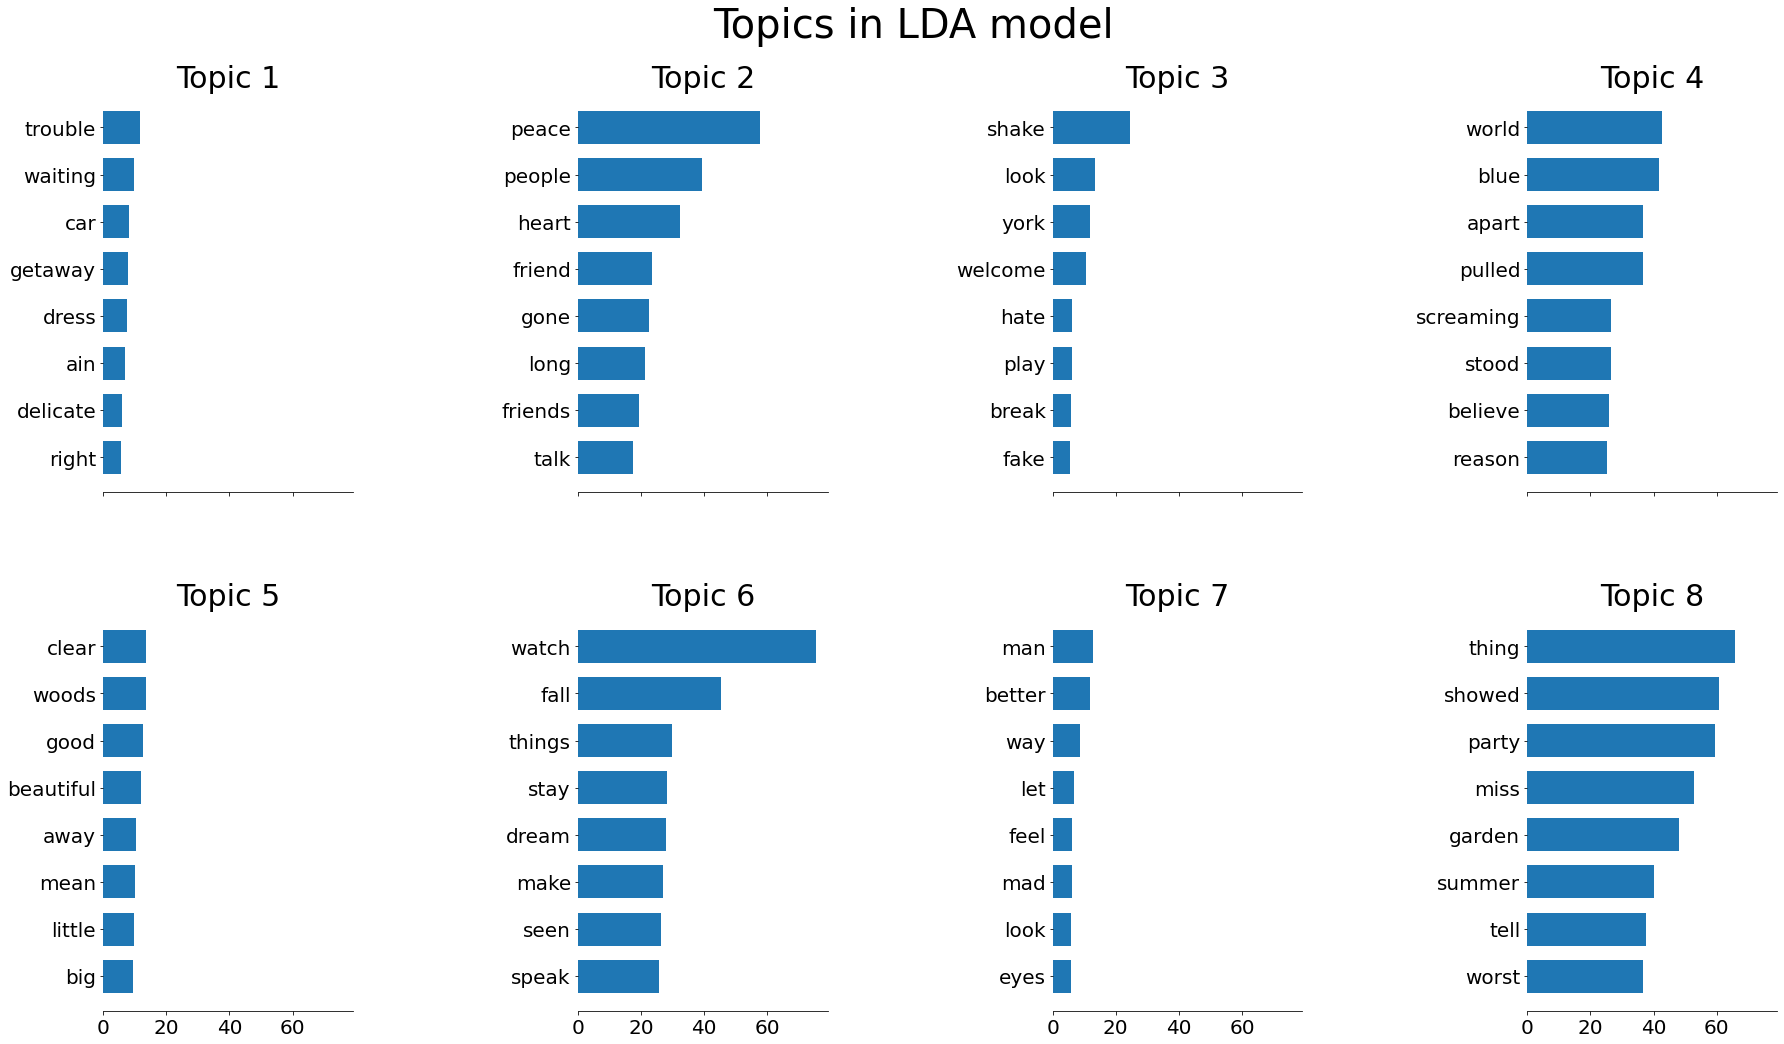

In [205]:
plot_top_words(
    lda, tf_feature_names, no_top_words, "Topics in LDA model"
)

* Topic 1: stay ("stay stay stay" from Red), red (in "Red"), help+way("Hey Stephen" from Red) -- but "woods" is clearly not from Red
* Topic 2: look ("look what you made me do" from Reputation)
* Topic 3: peace, heart, people ("Peace" from folklore); world, apart, blue("hoax" from folklore)
* Topic 4: daylight ("daylight" from Lover), trouble ("I knew you were trouble" from Red)
* Topic 5: watch, fall ("jump then fall" from Fearless)

### clusters

#### Explanation of k-means clustering: 
* Conventional k-means requires only a few steps. The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. Centroids are data points representing the center of a cluster.

* The main element of the algorithm works by a two-step process called expectation-maximization. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. Here’s what the conventional version of the k-means algorithm looks like:

* The quality of the cluster assignments is determined by computing the sum of the squared error (SSE) after the centroids converge, or match the previous iteration’s assignment. The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value.

-- source: https://realpython.com/k-means-clustering-python/

In [206]:
lyrics_taylor = taylor_df[['Lyrics']]

# remove punctuation
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# remove \n
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
# turn upper case to lower case
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: x.lower())
# remove some other words that don't have actual meanings and words that exist in multiple albums 

remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'know', 'wanna',
                'never', 'cause', 'like', 'back', 'love', 'just', 'come', 'got', 'baby', 'would', 'could','na','eeh', 'hoo',
                'think', 'goes', 'new', 'got', 'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'knew', 'didn',
                "see", "wishing", "gotta", "begin", "burn", "came", "tell", "watch", "does"]
pat = r'\b(?:{})\b'.format('|'.join(remove_words))
# lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].str.replace(pat, '')
long_lst = lyrics_taylor['Lyrics'].values.tolist()

tfidf_vectorizer = TfidfVectorizer(max_features=500,stop_words="english") # we set the max_features to 500, which means that we only consider the top 500 words based on their frequencies 
tfidf = tfidf_vectorizer.fit_transform(long_lst)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarni

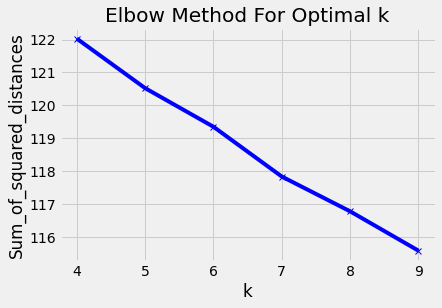

In [220]:
# use the elbow method
sum_of_squared_distances = []
for k in range(4,10):
    number_of_clusters = k
    km = KMeans(n_clusters=number_of_clusters, n_init=15, random_state=0, n_jobs=-1)
    # Normally people fit the matrix
    km.fit(tfidf)
    sum_of_squared_distances.append(km.inertia_)

    plt.style.use("fivethirtyeight")
plt.plot(range(4,10), sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()   

Here, we could see the optimal k is probably 7. 

In [221]:
#Generate cluster predictions and store in y_hat
#y_hat = km.predict(tfidf)
km = KMeans(n_clusters=7, n_init=15, random_state=0, n_jobs=-1)
km.fit(tfidf)
labels = km.labels_

#print('labels are: ', labels)
print("The lowest SSE value:", km.inertia_)


The lowest SSE value: 117.83983273203246


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


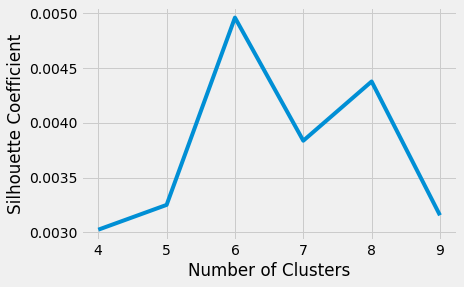

In [230]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
for k in range(4, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf)
    score = silhouette_score(tfidf, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(4, 10), silhouette_coefficients)
plt.xticks(range(4,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [232]:
#The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
#The Silhouette Coefficient for a sample is (b-a) / max(b-a)

score = metrics.silhouette_score(tfidf, labels, metric = 'euclidean')

print('the silhouette score is: ', score)

#The Calinski Harabasz Score or Variance Ratio is the ratio between within-cluster dispersion and between-cluster dispersion
# It is also known as the Variance Ratio Criterion.
# it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters
# the higher the score , the better the performances.

cali_score = metrics.calinski_harabasz_score(tfidf.toarray(), labels)
print('the Calinski Harabasz score is:', cali_score)

# print("Top terms per cluster:")
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vectorizer.get_feature_names()
# for i in range(number_of_clusters):
#     top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
#     print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

the score is:  0.006271277957586861
the Calinski Harabasz score is: 1.451006596639425


### Let's try again with simulations

In [288]:
# Let's set cluster number as 7 (based on what we have learned so far)
# BEGIN OUR SIMULATION!

#########set up 
number_of_clusters = 20
km_new = KMeans(n_clusters=number_of_clusters, n_init=15, random_state=0, n_jobs=-1)

lyrics_taylor = taylor_df[['Lyrics']]

# remove punctuation
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# remove \n
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
# turn upper case to lower case
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: x.lower())
# remove some other words that don't have actual meanings and words that exist in multiple albums 

# remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'know', 'wanna',
#                 'never', 'cause', 'like', 'back', 'love', 'just', 'come', 'got', 'baby', 'would', 'could','na','eeh', 'hoo',
#                 'think', 'goes', 'new', 'got', 'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'knew', 'didn',
#                 "see", "wishing", "gotta", "begin", "burn", "came", "tell", "watch", "does", "mmm", "eh", "mm"]

remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'know', 'wanna',
                'never', 'cause','just', 'come', 'got', 'baby', 'would', 'could','na','eeh', 'hoo',
                'goes', 'got', 'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'didn', "ain","usin",
                "see", "mmm", "eh", "mm", "unless", "oooh"]
pat = r'\b(?:{})\b'.format('|'.join(remove_words))
# lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].str.replace(pat, '')
long_lst = lyrics_taylor['Lyrics'].values.tolist()


######### randomly select 60% of the data
new_feature = []

for t in range(40):
    sample_list = random_select_from_lst(long_lst, 0.6)
    tfidf_vectorizer = TfidfVectorizer(max_features=500,stop_words="english") # we set the max_features to 500, which means that we only consider the top 500 words based on their frequencies 
    tfidf_new = tfidf_vectorizer.fit_transform(sample_list)
    #tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    km_new.fit(tfidf_new)
    order_centroids = km_new.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names()
    
    print('Time of Simulation:', t)
    for i in range(number_of_clusters):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
        print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))
        new_feature.append(" ".join(top_ten_words))
    print("  ")



C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Time of Simulation: 0
Cluster 0: follow treacherous slope wildest home dreams lips sunset cheeks sleepless
Cluster 1: lover forever close home meet save place enchanted struck make
Cluster 2: better soon changed best day today home supposed run making
Cluster 3: rest doin lord drug save life blame doesn crazy lovin
Cluster 4: begin games let middle ready dreams island night breeze low
Cluster 5: break shake perfectly heels tallest tiptoes highest spinning love café
Cluster 6: betty finally showed party garden thing miss clean worst seventeen
Cluster 7: peace friend bought people cascade brittle dress silence secret ocean
Cluster 8: song late amen tapping sneaking slow slamming screen date mama
Cluster 9: man careful daughter careless rebel yes remember thing water best
Cluster 10: burn really heartbreak redneck match lying pickup truck wasted bad
Cluster 11: love daylight coming saw good busy game state worth grace
Cluster 12: woman marvelous mad ruining seen like likes shame house cra

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 1
Cluster 0: paper rings darling right went frames accidents marry shiny dreams
Cluster 1: better loved gorgeous feel way stayed look changed face wishing
Cluster 2: delicate cool chill soon make promises drink reputation worse head
Cluster 3: meetings dies million times lie leave clandestine stares little single
Cluster 4: red love starlight like best talk day getting fancy dancing
Cluster 5: think bless soul mean hope tim mcgraw finally waiting gotta
Cluster 6: dance dancing fearless tonight tied like hands holy nights ground
Cluster 7: rest save doin drug lord life blame crazy doesn lovin
Cluster 8: trying girl everybody place strong world pieces wanted wrong heels
Cluster 9: marvelous ruining town woman seen money showed house rebekah holiday
Cluster 10: summer cruel garden roll betty thing worst rules shape breakable
Cluster 11: asking shake eye shouldn break list blink word heart twice
Cluster 12: wish speak vow church yes run meet door single hear
Cluster 13:

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 2
Cluster 0: wish grow killing story crowded like broke fate dying stay
Cluster 1: love places woods clear endgame beautiful peace fancy good big
Cluster 2: way help feeling miss aah sinks york dance long guess
Cluster 3: man talk shake window song open laugh tired anymore hoping
Cluster 4: better soon supposed changed pray won think mind make like
Cluster 5: summer showed betty thing getaway finally times garden car party
Cluster 6: everybody girl home look phone lose fine learned turn stupid
Cluster 7: gotta dancing like tied little middle spelling stars untouchable feels
Cluster 8: worship false god blind love faith away led altar hips
Cluster 9: sorry lose need hurt afterglow meant burned tell movie til
Cluster 10: lover forever close save home place make living string force
Cluster 11: rains feel forever good light bedroom hasn stare called flashback
Cluster 12: calm need loud stop like step somebody glaad gown street
Cluster 13: starlight dancing tune nines im

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 3
Cluster 0: need lose break sorry afterglow meant hurt burned thought like
Cluster 1: friend nice snow home like video tents sounds bells bell
Cluster 2: sittin given thinkin ending died shame perfect rainy away cold
Cluster 3: talk leave rain window hoping anymore tired open man laugh
Cluster 4: better belong wonderland getaway people mind think car like betty
Cluster 5: wednesday begin café watched months strange spending funny think throw
Cluster 6: innocent wasn bright string wait believed thirty lost lights crowd
Cluster 7: think hope mcgraw tim favorite happiness chest blue string song
Cluster 8: knew loved missing standing breakin young way lipstick like felt
Cluster 9: remember trying yes maybe like tell romeo doing cruel wanted
Cluster 10: wish stay fall december jump marvelous seen tells breath somebody
Cluster 11: beautiful gorgeous love tragic sad invisible way light face magic
Cluster 12: bad places blood burn really win stupid heartbreak run whisper
C

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 4
Cluster 0: like friend promise fun feels nights bought best nice remember
Cluster 1: thousand cuts death flickering chandelier boarded windows touch pretend tryna
Cluster 2: mamas used joke looked shined eyes pretty stars sky years
Cluster 3: think wednesday begin café watched heels laughing highest shining burn
Cluster 4: tell insane lucky love style lovers game list worth loved
Cluster 5: belong jump fall shine love life doin rest save people
Cluster 6: live long pretenders bring crashed screaming kingdom remembered walls shined
Cluster 7: innocent sorry bright wasn string anymore wait lost crowd thirty
Cluster 8: died given rainy ending shame thinkin cold perfect sittin defending
Cluster 9: talk getting friends telling like called miss used remember mean
Cluster 10: forever lips like kiss follow thought clothes sit imagined rains
Cluster 11: half gotta dream untouchable spelling middle little stars million feel
Cluster 12: endgame big reputation mean string tea

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 5
Cluster 0: stay mad grow gorgeous think loving funny face quite best
Cluster 1: look betty thing showed times leave style little need garden
Cluster 2: red trouble innocent light remember like movie good lost til
Cluster 3: think hope follow better mcgraw tim revenge mind stealing doing
Cluster 4: fly smile sparks eyes superstar superman away gimme green sidewalk
Cluster 5: trying wanted curve regrets hard lot maybe quite screen having
Cluster 6: breathin watch serve fall sense minutes glimpse relief epiphany seen
Cluster 7: love beautiful folk high worry tell passed rocks makes people
Cluster 8: story lucky killing tell like ending romeo tragedy easy breathe
Cluster 9: nice things darling forgot rings wouldn friends existed paper honey
Cluster 10: hold memories recognize floor stranger laugh cleaning midnights bottles year
Cluster 11: shake bought dress waiting friend best soul body pining holding
Cluster 12: live long pretenders bring crashed screaming walls rem

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 6
Cluster 0: movie belong like outside work sorry came til stand rain
Cluster 1: love places like folk won tell promise passed romeo sweet
Cluster 2: gone thought figured forgot leave shouldn wrong existed terribly breathe
Cluster 3: starlight marvelous day dancing seen summer dream like ruining romantics
Cluster 4: red wildest follow dreams starin rosy sunset cheeks lips babe
Cluster 5: think hope bless cornelia finally tim mcgraw street clean walk
Cluster 6: shake fake hate play break haters fakers stop heartbreakers people
Cluster 7: rains forever feel wonderland bedroom wrong hasn stare low gone
Cluster 8: endgame big reputation string team miss heard like bad love
Cluster 9: hold right stay live tied long smile memories screaming pretenders
Cluster 10: sick yes took tell tired temper remember doing cover streak
Cluster 11: need lose calm sorry afterglow meant burned hurt late meet
Cluster 12: look everybody nights wishing feels like home girl tears dead
Cluster

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 7
Cluster 0: gotta mean rains like begin middle games night missing shining
Cluster 1: beautiful love stay tragic piece leads looked magic hope ask
Cluster 2: day stayed look sittin wishing sky used best years cold
Cluster 3: mad woman gorgeous marvelous angry crazy like ruining likes face
Cluster 4: getaway car heart break met far perfectly ridin good place
Cluster 5: think hope tim mcgraw clean finally blue happiness chest jeans
Cluster 6: blood bad problems solve live look used remember cut em
Cluster 7: hope august case plans remember away canceled twisted bottle slipped
Cluster 8: lucky tell lights loves everybody let pretty took look feel
Cluster 9: york welcome new waiting summer body soul betty cruel garden
Cluster 10: shouldn thought gone twice begging word forgiveness feet asking bout
Cluster 11: man song late sneaking tapping screen slamming amen play date
Cluster 12: love wish light invisible jump smile unbelievable way instead shine
Cluster 13: halleluj

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 8
Cluster 0: hope beautiful stay think leads piece love august little looked
Cluster 1: better soon changed wonderland think like mind things hello held
Cluster 2: girl works everybody lucky tell trying wait place worse strong
Cluster 3: dies meetings million times lie leave affairs kid little single
Cluster 4: knew sadness way shade pulled apart loved love light invisible
Cluster 5: dance new welcome dancing york holy like lookin tonight walking
Cluster 6: mamas used pretty seven rolled daddies smiled eighty shined looked
Cluster 7: woods clear remember looking good flying discovered decided december sun
Cluster 8: drew wishing break perfectly teardrops guitar singing reason car heart
Cluster 9: daylight golden things sleepin year love look believed thought saw
Cluster 10: follow treacherous slope home reckless safe headlights think sleepless worth
Cluster 11: love worship false god faith blind away religion hips altar
Cluster 12: talk man right anymore tired getti

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 9
Cluster 0: mamas seven used sky rolled daddies smiled eighty eyes pretty
Cluster 1: rest drug lord doin save life doesn blame crazy lovin
Cluster 2: beautiful leads stay piece looked hope love door ask really
Cluster 3: like people peace think delicate better warm love brother best
Cluster 4: movie outside hallelujah like stand work til sorry came rain
Cluster 5: good break perfectly shake heart asking woods tear clear apart
Cluster 6: showed betty marvelous party garden thing seventeen ruining worst miss
Cluster 7: december realized turn missing swallowing turns freedom pride wishing standing
Cluster 8: wish feel like lips help watch talk breathin forever worship
Cluster 9: look starring trusts check actress bad nick trust dreams dead
Cluster 10: girl trying strong world place wrong life bad blue okay
Cluster 11: mad trouble woman angry shame like likes crazy does went
Cluster 12: highest mirrorball tallest heels tiptoes hush shining spinning try version
Cluster 

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 10
Cluster 0: style innocent like walking daydream sick tell took crashing thing
Cluster 1: story killing ending romeo breathe like tragedy easy speaking twist
Cluster 2: starlight dancing dream like nines impossible tune marvelous dressed moved
Cluster 3: love long jump beautiful tell boy like summer fall live
Cluster 4: nice friend bought things dress home shaking like lately best
Cluster 5: loved breakin way roller kissin coaster screamin fightin cursin feel
Cluster 6: knew waiting soul apart body missing shade moment pulled king
Cluster 7: better changed wonderland soon yesterday hello making eyes held simple
Cluster 8: dance fearless dancing holy lookin tonight stood ground right dress
Cluster 9: trying wanted hold hard stranger memories lot quite maybe party
Cluster 10: december realized freedom swallowing turn turns missing pride standing wishing
Cluster 11: grow stay darling little grown let simple wish won lock
Cluster 12: man lover forever sick close fast 

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 11
Cluster 0: peace brittle wave details people die brother friend secret heart
Cluster 1: live long pretenders bring crashed screaming walls remembered kingdom magic
Cluster 2: think hope tim mcgraw bet cornelia blue dress street young
Cluster 3: help stephen superstar angel feeling magic shine feel rain things
Cluster 4: million little style meetings dies times lie leave clandestine stares
Cluster 5: trying half crazy girl true matter fly wanted ground drive
Cluster 6: song late slamming sneaking amen tapping date screen real mama
Cluster 7: watch fly superman away breathin wishing save day sparks forget
Cluster 8: late horse white princess catch small sweep dreamer fairy tale
Cluster 9: asking eye list shouldn blink break missing heart door moment
Cluster 10: mamas used seven daddies smiled eighty rolled joke looked pretty
Cluster 11: calm need loud stop like somebody step gown street sign
Cluster 12: mean big endgame gotta someday reputation hit city living old


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 12
Cluster 0: trying girl everybody wanted hard lot quite maybe wrong home
Cluster 1: grow stay wish darling little grown simple let remember won
Cluster 2: folk love passed tea cross recall lasts won picture tell
Cluster 3: peace easy people breathe clear woods friend sorry save secret
Cluster 4: horse late princess white catch small town dreamer sweep stairwell
Cluster 5: live trouble long pretenders bring screaming crashed walls remembered kingdom
Cluster 6: welcome york new waitin blind bright beat lights dance everybody
Cluster 7: getaway car ridin met far place think sirens flyin known
Cluster 8: nice things darling rings paper friends went wouldn right honey
Cluster 9: love daylight beautiful endgame meet thousand cuts look pretty reputation
Cluster 10: red style crashing tight classic skirt dean eye heard james
Cluster 11: think bet hope finally clean string months dress young little
Cluster 12: defense marvelous fun roaring pool different shit doing ruining

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 13
Cluster 0: stay grow lock palm let late easy people hand darling
Cluster 1: look dress young dear known follow lover home john messed
Cluster 2: movie like outside til stand sorry work rain came locked
Cluster 3: cornelia street walk hope screams lose city terrified mystified ends
Cluster 4: rains feel forever bedroom hasn stare wrong low gone flashback
Cluster 5: boy tells fancy deep breath somebody love believe london supposed
Cluster 6: trying wanted half hard regrets curve crazy feel lot true
Cluster 7: daylight used mamas pretty seven looked eyes joke shined string
Cluster 8: tied undone smile letting coming jumping water golden losing high
Cluster 9: summer walking thing betty like garden cruel right party new
Cluster 10: loved way breakin feel roller coaster screamin cursin fightin rush
Cluster 11: marvelous woman ruining mad seen money showed town house american
Cluster 12: wish breathin watch speak vow single meet yes run door
Cluster 13: woods clear goo

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 14
Cluster 0: leave movie rain like outside thought gone stand times window
Cluster 1: knew invisible gorgeous light string think like young way make
Cluster 2: belong bout understands cheer wears dreamin bleachers captain standin waitin
Cluster 3: nice friend things forgot existed darling wouldn snow home lately
Cluster 4: half trying crazy girl true feel fly matter like ground
Cluster 5: jump fall shine smile ma catch afraid way leave stay
Cluster 6: tell lucky believe tired bet sick feeling tells somebody night
Cluster 7: break perfectly good tear wednesday café begin heart scar apart
Cluster 8: december missing wishing standing sorry gave grace realized loved freedom
Cluster 9: wish girl speak vow works wait meet church yes run
Cluster 10: stay right grow combat darling prey archer easy help hold
Cluster 11: best better home today day run style look fearless set
Cluster 12: peace people cascade brittle wave ocean blues secret devil warm
Cluster 13: places outsid

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 15
Cluster 0: cornelia street walk hope screams lose mystified terrified city ends
Cluster 1: remember man careful daughter careless thing rebel yes maybe best
Cluster 2: clean finally breathe easy trace drowning think months pouring sorry
Cluster 3: superstar dim photograph special spotlight desperately wall eyed wide hang
Cluster 4: sadness knew pulled shade apart blue world broken hurts scars
Cluster 5: knew young assume cardigan like felt favorite bed old missing
Cluster 6: light help invisible way miracle unbelievable eyes let smile instead
Cluster 7: gorgeous face hate furious turns happy feel makes sad look
Cluster 8: hope bet august think away meet case plans speak run
Cluster 9: wishing lucky car cursing getaway stayed tell drew teardrops ricochet
Cluster 10: shame thinkin rainy given perfect died sittin ending cold day
Cluster 11: shouldn twice forgiveness begging feet asking word bout gone thought
Cluster 12: fearless dress shake bought best hands drag da

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 16
Cluster 0: getaway car far ridin met place starts flyin known ahh
Cluster 1: paper rings darling went marry picture friends dreams right kiss
Cluster 2: mean big someday gotta endgame living old hit reputation city
Cluster 3: rains forever feel bedroom hasn stare wrong low flashback gone
Cluster 4: follow treacherous slope wildest home dreams lips echoed drive shine
Cluster 5: red remember like promise love innocent worship shouldn fun lost
Cluster 6: forgot existed nice friend indifference ground peaceful quiet hate kill
Cluster 7: better soon wonderland changed supposed lost hello yesterday won make
Cluster 8: talk getting friends telling like used miss called remember space
Cluster 9: gorgeous dress song bought young dear way shining look insane
Cluster 10: waiting breathin watch soul body breath tells deep king fall
Cluster 11: outside trouble places lookin view lets lonely lot better best
Cluster 12: belong bout understands wear waitin dreamin doesn wake thi

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 17
Cluster 0: everybody gorgeous tells breath look somebody deep girl abigail believe
Cluster 1: better soon stealing revenge think mind people mattress playground applause
Cluster 2: finally clean hallelujah drowning trace pouring think months breathe morning
Cluster 3: fancy london boy love mates likes enjoy tennessee highgate child
Cluster 4: stay grow palm lock easy let people late hand like
Cluster 5: marvelous ruining woman money seen showed town house american little
Cluster 6: summer cruel coming roll garden right breakable rules worth heaven
Cluster 7: half crazy true trying matter ground drive fly feel live
Cluster 8: gave signs december sign warning film think read string learned
Cluster 9: starlight dancing tune nines impossible moved dressed like dream marvelous
Cluster 10: breathin watch serve fall relief glimpse epiphany speak minutes sleep
Cluster 11: dancing tied hands dress feeling bought bad friend world best
Cluster 12: good break perfectly shake

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 18
Cluster 0: starlight dancing romantics dream like build best castle threw free
Cluster 1: fun promise leaving pool doing hit true think came like
Cluster 2: man mean feeling like sick believe yes summer thing tell
Cluster 3: begin café wednesday watched spending does think strange throw burn
Cluster 4: dance fearless better soon drag storm dress gets best hand
Cluster 5: innocent wasn string cuts bright lost okay thousand lights alright
Cluster 6: grow wish stay right darling little grown simple ready hold
Cluster 7: marvelous ruining seen gave woman house town signs money showed
Cluster 8: trying wanted girl hard half curve maybe feel crazy lot
Cluster 9: love help jump smile folk passed like beautiful sweet fall
Cluster 10: thought gone figured leave terribly holding breathe haunted wrong like
Cluster 11: love good daylight long wishing grace save fancy light live
Cluster 12: lucky tell lights pretty loves let everybody feel took look
Cluster 13: outside movie 

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 19
Cluster 0: peace people breathe friend easy wave brittle details blues secret
Cluster 1: stay right easy palm lock people late combat hand let
Cluster 2: beautiful bless love smile invisible superstar stay eyes think leads
Cluster 3: remember red trying starlight woods talk like worship getting clear
Cluster 4: burn bad really soon heartbreak redneck pickup strike truck stupid
Cluster 5: asking eye list blink break heart times door eyes better
Cluster 6: girl everybody works lucky look tell home young wait trying
Cluster 7: grow stay little darling grown simple wish won remember nightlight
Cluster 8: wishing bet car drew getaway teardrops reason singing guitar cursing
Cluster 9: guess london feeling aah miss sinks fancy york today way
Cluster 10: need calm loud lose like stop step somebody meet glaad
Cluster 11: nice daylight things friend wouldn hear darling think lately honey
Cluster 12: walking fly like half stream brand jet scene daydream high
Cluster 13: lat

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 20
Cluster 0: fearless dress hands dance best dancing tied bought drag storm
Cluster 1: jump fall shine smile way today feeling catch ma afraid
Cluster 2: folk passed long live love tea lasts won recall picture
Cluster 3: hold memories recognize stranger floor midnights cleaning bottles laugh year
Cluster 4: wonderland think better known revenge stealing mind toys applause mattress
Cluster 5: red look style crashing like loving burning trying girl daydream
Cluster 6: nice friend things snow home lately darling wouldn church sinks
Cluster 7: man late getaway lover song talk car window forever horse
Cluster 8: knew assume young cardigan felt favorite bed apart pulled like
Cluster 9: hope august think case plans remember away bottle mall sipped
Cluster 10: missing december standing moment motion impress knew happy lipstick slow
Cluster 11: sorry rains like innocent tell movie lose need breathe easy
Cluster 12: mad stay woman angry crazy like shame think does loving
Clu

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 21
Cluster 0: worship false god blind faith love away warned altar hips
Cluster 1: bad win endgame good light big reputation world catch fight
Cluster 2: mad woman stay marvelous fun think ruining showed came hit
Cluster 3: trying girl wanted place wrong maybe world life quite hard
Cluster 4: ending rainy thinkin given shame sittin died cold perfect day
Cluster 5: wish fall things bless december nice cornelia like night breathin
Cluster 6: careless careful daughter rebel man remember water yes thing best
Cluster 7: girl works wonderland wait worse better vow lost speak door
Cluster 8: tied undone letting smile golden jumping coming losing water hold
Cluster 9: rest lord doin drug save life blame crazy doesn lovin
Cluster 10: trouble knew york sadness welcome apart shade pulled new cliffside
Cluster 11: romeo story yes waiting juliet love daddy beggin princess close
Cluster 12: red belong car getaway rains remember innocent wishing bout singing
Cluster 13: friend pea

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 22
Cluster 0: belong calm need like killing bout story understands loud room
Cluster 1: starlight meet enchanted spend struck wonder wondering dancing forever night
Cluster 2: look hold getaway bet car today remember long miss run
Cluster 3: better soon think asking wonderland mind shouldn people little throw
Cluster 4: thousand cuts death touch windows boarded chandelier flickering wasn love
Cluster 5: dance fearless late lookin drag outside horse best storm better
Cluster 6: daylight golden things sleepin look love believed year dark saw
Cluster 7: mad woman angry crazy like shame likes went does poke
Cluster 8: gave string tying color invisible signs think pretty used gold
Cluster 9: good bad light feel wildest rains blood dreams perfectly lips
Cluster 10: undone coming tied smile letting water jumping losing golden hold
Cluster 11: sorry breathe easy like movie gone thought save clean people
Cluster 12: fancy boy london love highgate rumors enjoy mates child ten

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 23
Cluster 0: waiting begin let soul games meet enchanted body king struck
Cluster 1: think signs gave mind film warning read sign things seen
Cluster 2: need calm like loud stop somebody step glaad gown street
Cluster 3: mean big someday gotta endgame living old hit city reputation
Cluster 4: fearless dress shake bought best dance hands gets drag friend
Cluster 5: fall jump breathin watch shine smile ma catch afraid way
Cluster 6: million little lie meetings dies times illicit stares leave single
Cluster 7: gone thought figured leave terribly forgot haunted holding wrong breathe
Cluster 8: welcome york new innocent bright waitin wasn lights string lost
Cluster 9: girl works wait vow speak church meet door yes run
Cluster 10: delicate cool chill soon make promises drink reputation worse head
Cluster 11: girl trying strong place world wrong life mystery mission fly
Cluster 12: asking eye follow treacherous list slope blink break home heart
Cluster 13: mad woman gorge

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 24
Cluster 0: marvelous ruining seen house woman town money showed american gave
Cluster 1: fancy stayed love cursing used london best boy sky years
Cluster 2: need mean calm door leave pebbles throwing pouring wait stand
Cluster 3: blood bad live solve problems mad used deep cut think
Cluster 4: defense fun wishes twenties pennies greatest roaring shit pool different
Cluster 5: everybody look girl style home crashing red like proposition check
Cluster 6: fearless dance storm drag dress gets head hand best better
Cluster 7: shake fake break hate play fakers haters heartbreakers players people
Cluster 8: gorgeous insane undone way smile loved face feel tell love
Cluster 9: trouble york apart knew welcome break new perfectly believe careless
Cluster 10: dies meetings times lie million illicit affairs clandestine kid stares
Cluster 11: talk open clear hoping window anymore tired woods song rain
Cluster 12: movie sorry like remember work outside til gone rain came
Clust

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 25
Cluster 0: meet forever enchanted wonder spend wondering struck lover let enchanting
Cluster 1: look mean style day long pretty best song little sittin
Cluster 2: belong bout understands waitin cheer dreamin standin wake doesn wear
Cluster 3: nice friend forgot things wildest existed snow dreams babe home
Cluster 4: worship false god blind faith love away gets religion crazy
Cluster 5: better places outside soon lookin lets view lot changed lonely
Cluster 6: shake romantics build bricks threw castle life new battle free
Cluster 7: fun promise doing sick tell yes like think tired came
Cluster 8: hush tallest shining tiptoes mirrorball highest spinning heels try version
Cluster 9: bad everybody blood pieces caught girl break counting perfectly number
Cluster 10: getaway car far ridin place met known think mystery ahh
Cluster 11: like dancing delicate dance tied nights walking gotta hands feels
Cluster 12: trouble knew killing walked young like flew shade pulled sto

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 26
Cluster 0: leave tell little insane lovers love kid wait speak ex
Cluster 1: movie sorry like waiting hallelujah mad stand woman outside soul
Cluster 2: dancing dance tied hands starlight feeling tonight holy lookin like
Cluster 3: man shake sick fake coming fast break careful daughter careless
Cluster 4: walking stream jet like loves fit scene daydream head brand
Cluster 5: everybody look girl home proposition phone fine lose trust cab
Cluster 6: light invisible daylight think instead way love eyes string make
Cluster 7: new york guess welcome endgame wasn innocent summer feeling cuts
Cluster 8: cornelia street walk hope screams lose city terrified mystified ends
Cluster 9: forever blood hold lover floor lips sit end imagined clothes
Cluster 10: superstar photograph eyed wall dim special spotlight desperately wide smile
Cluster 11: places outside lookin foxes track hunters tails run won hide
Cluster 12: forgot existed indifference clear woods hate peaceful quiet

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 27
Cluster 0: million little times lie middle gotta spelling dream leave stares
Cluster 1: beautiful think help love invisible bless light magic way tragic
Cluster 2: talk clear woods anymore getting open hoping rain window tired
Cluster 3: sorry meet lose need vow speak cornelia run white kind
Cluster 4: red follow dreams wildest treacherous paper rings slope darling went
Cluster 5: nice friend bought things dress snow home shaking like lately
Cluster 6: romantics new build castle bricks battle free threw dream life
Cluster 7: mad stay hold woman memories angry stranger floor crazy like
Cluster 8: outside movie waiting easy sorry breathe soul body like lookin
Cluster 9: man careful careless daughter rebel remember yes thing best water
Cluster 10: gorgeous look shake hate face furious turns happy feel makes
Cluster 11: today hallelujah run fall way day away best home cried
Cluster 12: worry throw love rocks makes people rough stakes pretty shine
Cluster 13: knew tro

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 28
Cluster 0: light beautiful invisible eyes love like calm unbelievable need stop
Cluster 1: hold hallelujah memories recognize stranger tied floor sing laugh bottles
Cluster 2: loved way breakin feel cursin fightin coaster rush roller knew
Cluster 3: red follow wildest dreams treacherous rosy sunset lips starin cheeks
Cluster 4: hope think belong getaway bet car cornelia tim mcgraw street
Cluster 5: waiting romeo yes story juliet soul love body king princess
Cluster 6: lucky tell lover forever lights make close place let everybody
Cluster 7: mind people think better things revenge stealing signs playground actress
Cluster 8: girl works everybody trying wait worse home world wrong cheeks
Cluster 9: daylight golden things sleepin look love year believed dark thought
Cluster 10: new dance welcome york dancing romantics like day battle tonight
Cluster 11: bad marvelous ruining win seen town woman american girl money
Cluster 12: trouble trying outside lot places wanted

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 29
Cluster 0: shining mirrorball tiptoes hush highest tallest spinning heels young dear
Cluster 1: fearless shake dance drag gets storm hand better head dress
Cluster 2: lose need sorry hurt tell meet afterglow meant door movie
Cluster 3: think hope tim mcgraw bless bet blue night happiness chest
Cluster 4: promise fun like lot team chicks spell girl guys strike
Cluster 5: bought dress friend best holding patience pining shaking hands silence
Cluster 6: new york welcome daylight innocent romantics bright life waitin wasn
Cluster 7: man remember careful careless daughter yes sick rebel thing water
Cluster 8: style crashing lip classic skirt dean james eye heard girl
Cluster 9: forever rains lover lips sparks wildest meet feel close fly
Cluster 10: wish drew wishing teardrops guitar singing reason car song star
Cluster 11: stay right easy darling help hold lock leave years late
Cluster 12: finally clean drowning trace think months pouring breathe came morning
Cluster 

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 30
Cluster 0: waiting december sorry lose movie need soul body til like
Cluster 1: better soon changed think stealing people won mind make like
Cluster 2: red follow wildest dreams treacherous rosy cheeks starin sunset babe
Cluster 3: things nice darling daylight grow forgot hear existed friends rings
Cluster 4: easy breathe sorry killing save people simple clean story like
Cluster 5: fly betty showed thing times new party garden york walking
Cluster 6: rains forever feel bedroom gone hasn stare low flashback wrong
Cluster 7: good right coming saw light state game stay love grace
Cluster 8: hope august think case plans remember canceled bottle sipped bedsheets
Cluster 9: shake fake play hate break haters fakers stop heartbreakers players
Cluster 10: delicate cool chill drink promises make soon head worse reputation
Cluster 11: hallelujah sing revolution fight walls things hold win stand finally
Cluster 12: beautiful love tragic highest shining spinning heels magic t

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 31
Cluster 0: delicate cool soon make worse head babe reputation like best
Cluster 1: knew way light right smile invisible eyes like love jump
Cluster 2: style walking daydream crashing like thing jet scene stream fit
Cluster 3: talk window hoping clear tired woods anymore man open rain
Cluster 4: romeo story princess yes waiting juliet love white killing late
Cluster 5: sorry easy breathe movie like people break lose save knew
Cluster 6: gave signs december sign film warning think learned read seen
Cluster 7: promise fun trouble like lot team awesome spell doll band
Cluster 8: drug rest lord doin life save blame crazy doesn lovin
Cluster 9: nice follow bet dress dreams bought things darling wildest rings
Cluster 10: finally clean trace pouring drowning think months morning came breathe
Cluster 11: innocent wonderland wasn lost bright string wait lights life thirty
Cluster 12: belong bout understands thinkin dreamin wears bleachers cheer captain waitin
Cluster 13: l

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 32
Cluster 0: dancing tied hands dance feeling like feels nights tonight water
Cluster 1: gave signs seen film sign warning read marvelous think ruining
Cluster 2: bought dress friend best patience pining shaking silence hands holding
Cluster 3: betty summer endgame garden party showed miss thing worst heard
Cluster 4: thought gone figured leave forgot terribly wrong breathe haunted holding
Cluster 5: sparks fly smile gimme drop pouring sidewalk haunt green lights
Cluster 6: meet enchanted struck wonder spend wondering forever knew enchanting sparkling
Cluster 7: everybody girl lucky home look style tell crashing proposition heard
Cluster 8: beautiful love stay innocent wasn way loved need used like
Cluster 9: delicate promise cool fun like chill make soon drink promises
Cluster 10: begin throw café wednesday little games love think burn laughing
Cluster 11: knew york shade welcome sadness new scars apart died pulled
Cluster 12: man sick shake coming fast quicker pl

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 33
Cluster 0: mean bless gotta soul waiting big someday body king old
Cluster 1: rings paper darling went right shiny frames accidents marry picture
Cluster 2: invisible way light knew miracle instead loved love eyes beautiful
Cluster 3: movie outside like sorry came work rain til stand locked
Cluster 4: trouble places knew flew shame walked run tryin hide drowning
Cluster 5: man sick lover forever fast wondering coming careful careless daughter
Cluster 6: belong bout understands cheer dreamin wear wears waitin captain bleachers
Cluster 7: wildest nice bet dreams friend babe starin rosy sunset follow
Cluster 8: endgame big reputation string team miss heard like bad love
Cluster 9: lucky lose cornelia break tell need perfectly white walk meet
Cluster 10: delicate cool chill soon make promises drink head worse reputation
Cluster 11: love worship cuts thousand false death god touch came free
Cluster 12: remember getting talk woods like little clear lost bout hope
Clust

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 34
Cluster 0: light good smile invisible eyes sparks superstar fly feel bad
Cluster 1: think hope tim mcgraw bless cornelia street little blue walk
Cluster 2: daylight jump peace people shine love fall makes things rocks
Cluster 3: york need new aah feeling guess sinks miss today way
Cluster 4: knew assume young cardigan felt favorite like old bed kiss
Cluster 5: loved breakin way feel cursin insane coaster roller kissin fightin
Cluster 6: beautiful love romeo little superman tragic save stay away really
Cluster 7: nice friend things bought snow dress home shaking like best
Cluster 8: lucky tell took sick tired yes let feel lights like
Cluster 9: sorry asking missing december standing moment anymore easy impress motion
Cluster 10: young john messed known dear run cried girl think home
Cluster 11: lover forever wonderland close home save place make lost darling
Cluster 12: soon delicate better outside cool view lookin best lonely lot
Cluster 13: remember grow belong 

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 35
Cluster 0: nice things friend darling rings friends wildest dreams paper wouldn
Cluster 1: fearless dance drag storm gets dress hand best head better
Cluster 2: begin wednesday café walking watched like burn laughing kid spending
Cluster 3: hallelujah sing getting revolution fight walls talk things hold win
Cluster 4: soon better asking delicate outside best lookin make view try
Cluster 5: girl works wait worse cheeks broke better vow speak door
Cluster 6: cursing stayed wishing grace ricochet tears gather worst wake look
Cluster 7: beautiful tragic magic live love affair long sad wishing singing
Cluster 8: mamas used rolled seven daddies pretty shined joke stars looked
Cluster 9: daylight golden things sleepin believed look love year thought saw
Cluster 10: think young dress messed john known dear girl gone hope
Cluster 11: dancing tied starlight hands feeling bad like dance world dream
Cluster 12: wish trying red belong feeling like sorry wanted believe summer


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 36
Cluster 0: dancing shake romantics dream tied like build bricks castle free
Cluster 1: mad stay hold woman memories stranger crazy like floor loving
Cluster 2: love pretty mamas people hallelujah worry shine peace makes throw
Cluster 3: style red everybody girl crashing home look dean skirt classic
Cluster 4: better soon think daylight mind places wonderland delicate like home
Cluster 5: beautiful help stay piece leads looked love ask hope door
Cluster 6: jump fall smile shine ma afraid catch way stay leave
Cluster 7: good light man feel bad felt sick coming fast fun
Cluster 8: welcome york new waitin blind bright beat soundtrack dance lights
Cluster 9: knew loved missing way moment lipstick standing young felt like
Cluster 10: need calm street cornelia lose sorry easy walk breathe break
Cluster 11: speak vow run church meet door yes single kind wait
Cluster 12: promise fun lot like team lame girl lover strike band
Cluster 13: mean bet big someday city hope takes

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 37
Cluster 0: man need sick calm sorry tell like summer anymore cruel
Cluster 1: stay right grow combat darling archer prey easy help hold
Cluster 2: knew trouble pulled young apart scars blue world broken favorite
Cluster 3: tells breath deep somebody believe supposed doors abigail soon boy
Cluster 4: thought gone figured rains leave wrong terribly holding haunted breathe
Cluster 5: love hands blood bad worship romeo fancy dancing tied thousand
Cluster 6: watch fly superman away breathin day sparks save forget world
Cluster 7: december realized swallowing missing turn pride turns freedom standing wishing
Cluster 8: getaway car ridin met place far known sirens ahh flyin
Cluster 9: wonderland better lost pretended changed worse forever yesterday hello eyes
Cluster 10: hallelujah finally sing clean fight revolution walls hold things stand
Cluster 11: marvelous woman ruining mad seen house showed town money holiday
Cluster 12: remember woods promise style innocent clea

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 38
Cluster 0: shake walking like head kid thing little loves stream jet
Cluster 1: coming tied smile undone letting jumping golden water losing hold
Cluster 2: yes romeo tell run bet tired believe love sorry waiting
Cluster 3: song late talk window mama tapping sneaking slamming amen date
Cluster 4: gave signs seen marvelous sign read warning film think ruining
Cluster 5: places trouble dance lookin outside late horse view white lonely
Cluster 6: cornelia street walk hope lose screams mystified terrified city ends
Cluster 7: mamas daddies used seven stars eyes looked pretty sky joke
Cluster 8: worship false god blind faith love warned hips gets away
Cluster 9: mean big gotta someday old living hit city like somebody
Cluster 10: love daylight summer mad like picture woman won tell burn
Cluster 11: stay beautiful innocent light invisible love wasn way like eyes
Cluster 12: trying wanted half hard quite maybe lot feel crazy matter
Cluster 13: delicate cool chill soon m

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Time of Simulation: 39
Cluster 0: worry shine love rocks throw people pretty rough stakes makes
Cluster 1: lover forever close home save place make dear string scar
Cluster 2: lucky tell car wishing getaway break perfectly live long superstar
Cluster 3: think good doing light guess feeling feel fun took today
Cluster 4: like bet nights feels starlight gotta bless dancing alright night
Cluster 5: belong bout understands shouldn captain waitin bleachers cheer wears looking
Cluster 6: rest drug lord life doin save blame crazy doesn lovin
Cluster 7: look everybody red girl home help blood hallelujah boy fancy
Cluster 8: shake fake hate break play haters fakers stop heartbreakers players
Cluster 9: trying half fly true crazy matter ground drive superman wanted
Cluster 10: man coming sick fast quicker wondering saw good running okay
Cluster 11: soon better delicate make supposed cool chill best like hair
Cluster 12: places trouble burn run outside tails foxes hunters track tryin
Cluster 13: 

### Let's turn use the result from simulation as our new features 

In [289]:
new_feature

['follow treacherous slope wildest home dreams lips sunset cheeks sleepless',
 'lover forever close home meet save place enchanted struck make',
 'better soon changed best day today home supposed run making',
 'rest doin lord drug save life blame doesn crazy lovin',
 'begin games let middle ready dreams island night breeze low',
 'break shake perfectly heels tallest tiptoes highest spinning love café',
 'betty finally showed party garden thing miss clean worst seventeen',
 'peace friend bought people cascade brittle dress silence secret ocean',
 'song late amen tapping sneaking slow slamming screen date mama',
 'man careful daughter careless rebel yes remember thing water best',
 'burn really heartbreak redneck match lying pickup truck wasted bad',
 'love daylight coming saw good busy game state worth grace',
 'woman marvelous mad ruining seen like likes shame house crazy',
 'wish red boy waiting tells fancy deep somebody breath love',
 'stay mad hold loving think quite memories funny 

In [291]:
km_f = KMeans(n_clusters=8, n_init=15, random_state=0, n_jobs=-1)
tfidf_f = tfidf_vectorizer.fit_transform(new_feature)
km_f.fit(tfidf_f)

print("Top terms per cluster:")
order_centroids = km_f.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer_new.get_feature_names()
for i in range(8):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Top terms per cluster:
Cluster 0: check half struck rings car tired rocks flying took save
Cluster 1: chasing changed bedroom dancing fate kiss bless door gave string
Cluster 2: believe stars combat mean wondering loving today brittle worry list
Cluster 3: understands everybody warning cascade funny film watched shake dream singing
Cluster 4: fearless belong thought play dean remember guitar kiss meetings friends
Cluster 5: happy today treacherous make apart careful tails bet begging walls
Cluster 6: stay hung kiss memories miss angel daylight alright strange close
Cluster 7: lookin lips attitude throwing mamas december place discovered yes hands


In [292]:
labels = km_f.labels_

score = metrics.silhouette_score(tfidf_f, labels, metric = 'euclidean')

print('the silhouette score is: ', score)

the silhouette score is:  0.033474077285164404


we could see the silhouette score is now 0.03, which is higher than before (but still pretty low)

### Let's try another clustering approach

In [308]:
# from sklearn.datasets import make_blobs
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(
#     n_samples=300, centers=centers, cluster_std=0.5, random_state=0
# )
# print(labels_true)

In [316]:
from sklearn.cluster import DBSCAN
lyrics_taylor = taylor_df[['Lyrics']]

# remove punctuation
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# remove \n
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
# turn upper case to lower case
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: x.lower())
# remove some other words that don't have actual meanings and words that exist in multiple albums 

remove_words = ['oh', 'yeah', 'ah', 'uh', 've', 'hey', 'ey', 'don', 'll', 't', 'ooh', 'whoa', 'ha', 'huh', 'isn', 'know', 'wanna',
                'never', 'cause', 'like', 'back', 'love', 'just', 'come', 'got', 'baby', 'would', 'could','na','eeh', 'hoo',
                'think', 'goes', 'new', 'got', 'goes', 'time', 'want', 'did', 'knows', 'said', 'say', 'gonna', 'la', 'knew', 'didn',
                "see", "wishing", "gotta", "begin", "burn", "came", "tell", "watch", "does"]
pat = r'\b(?:{})\b'.format('|'.join(remove_words))
# lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].map(lambda x: re.sub('\n', ' ', x))
lyrics_taylor['Lyrics'] = lyrics_taylor['Lyrics'].str.replace(pat, '')
long_lst = lyrics_taylor['Lyrics'].values.tolist()

tfidf_vectorizer = TfidfVectorizer(max_features=500,stop_words="english") # we set the max_features to 500, which means that we only consider the top 500 words based on their frequencies 
tfidf = tfidf_vectorizer.fit_transform(long_lst)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# #############################################################################
# Compute DBSCAN
# Minimum samples (“MinPts”): the fewest number of points required to form a cluster
# ε (epsilon or “eps”): the maximum distance two points can be from one another while still belonging to the same cluster

db = DBSCAN(eps=10, min_samples=20).fit(tfidf)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

print(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(n_clusters_)
# #############################################################################
# Compute Affinity Propagation
# af = AffinityPropagation(preference=-50, random_state=0).fit(tfidf)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))




[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1


C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\lpeng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [298]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf_f, labels))

Estimated number of clusters: 0
Estimated number of noise points: 800


* cluster 1: 
* cluster 2: chasing
* cluster 3: understands (from "Fearless" and "Lover")
* cluster 4: fearless (from "Fearless"), belong ("You belong with me" from "Fearless"), 

* Cluster 0: holy("holy ground" from Red), asking("Treacherous" from Red --maybe?), lonely("22" from Red --maybe)
* Cluster 1: august,lost ("august" from folklore), sun ("august", "hoax", and "peace" from folklore), tonight/standing appears in folklore and also other albums
* Cluster 2: stephen, angel("hey stephen" from fearless); hallelujah ("change" from fearless), bless(from Lover), invisible(from "Invisible" in Fearless)
* Cluster 3: forgot ("I forgot that you existed" from Lover)

Cluster 0: 

cluster 1: "red", "everybody", and "starlight" are all from Red. "red" refers to her song "Red", while "everybody" appears frequently in her song "Girl at home". "Starlight" almost appears exclusively in her song "Starlight".It is a bit hard to tell if "lucky" here refers to "the lucky one" in Red because other songs in other album also has this word. "getaway" however only appears in "reputation". But it also shows up in the first cluster. 

cluster 7: better + soon ( "Soon you'll get better" from Lover); look+things (looks like "reputation") 


* Cluster 0: nice friend ("it's nice to have a friend" from Lover); forgot("I forgot that you existed" from Lover)
* Cluster 1: wish ("I wish you would" from 1989), long ("style" from 1989), shake("shake it off" from 1989), song(from "Taylor swift)
* 

* Cluster 0: better + soon ( "Soon you'll get better" from Lover); summer ("cruel summer" from Lover); things("paper ring" from Lover); 
* Cluster 1: welcome + york ("welcome to new york" from Reputation); getway("getaway car" from Reputation); 
* Cluster 2: red ("red" from Red), remember("say that you will remember me" from Red), dreams (from "wildest dream" -- looks like 1989) bet ("I bet you think about me" from Red), belong ("You belong with me" from Fearless) 
* Cluster 3: man ("the man" from Lover)
* Cluster 4: watch, fly, away, hope("Superman" from Speak Now)
* Cluster 5: girl, bad


#### Now, I am trying to randomize samples and see what words most likely to appear in each topic. 

In [34]:
new_dict = {0:{}, 1:{}, 2:{}, 3: {}, 4:{}, 5: {}, 6:{}, 7:{}}
def store_topics(long_lst, new_dict):
    #new_dict = {0:{}, 1:{}, 2:{}, 3: {}, 4:{}, 5: {}, 6:{}, 7:{}}
    
    sample_list = random_select_from_lst(long_lst, 0.6)
    tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words="english") # we set the max_features to 500, which means that we only consider the top 500 words based on their frequencies 
    tfidf = tfidf_vectorizer.fit_transform(sample_list)
    feature_names = tfidf_vectorizer.get_feature_names()
    nmf = NMF(n_components=topics, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    no_top_words = 8 
    
    
    for topic_idx, topic in enumerate(nmf.components_):
        #print("Topic %d:" % (topic_idx))
        lst_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        for word in lst_words:
            if word in new_dict[topic_idx]:
                new_dict[topic_idx][word] = new_dict[topic_idx][word] + 1
            else:
                new_dict[topic_idx][word] = 1
    return new_dict

no_top_words = 8

In [35]:
# randomly select 60% of data
# and let's do it 10 times and see what words repeatedly show up in each topic
long_lst = lyrics_taylor['Lyrics'].values.tolist()
dictionary = {}

for i in range(40):
    new_dict = store_topics(long_lst, new_dict)
    for k, v in new_dict.items():
        sort_orders = sorted(v.items(), key=lambda x: x[1], reverse=True)
        dictionary[k] = sort_orders
        
#print(dictionary)
    

In [36]:
#dictionary
for topic_num, lst in dictionary.items():
    print('Topic:', topic_num)
    print('Top words in each topic:', lst[0:8])

Topic: 0
Top words in each topic: [('girl', 6), ('forever', 5), ('gone', 5), ('bad', 5), ('lips', 4), ('remember', 4), ('need', 4), ('home', 4)]
Topic: 1
Top words in each topic: [('bad', 4), ('make', 4), ('mad', 4), ('dream', 4), ('dancing', 4), ('marvelous', 4), ('reputation', 3), ('soon', 3)]
Topic: 2
Top words in each topic: [('stay', 6), ('dancing', 4), ('way', 3), ('soon', 3), ('make', 3), ('best', 3), ('mad', 3), ('beautiful', 3)]
Topic: 3
Top words in each topic: [('right', 5), ('bad', 4), ('mad', 4), ('darling', 3), ('went', 3), ('used', 3), ('dancing', 3), ('hands', 3)]
Topic: 4
Top words in each topic: [('stay', 5), ('shine', 4), ('mad', 3), ('loving', 3), ('better', 3), ('make', 3), ('help', 3), ('way', 3)]
Topic: 5
Top words in each topic: [('better', 6), ('soon', 5), ('girl', 4), ('works', 4), ('stay', 4), ('break', 3), ('heart', 3), ('door', 3)]
Topic: 6
Top words in each topic: [('right', 6), ('stay', 4), ('bad', 3), ('remember', 3), ('fall', 3), ('leave', 3), ('easy', 

* Topic 1: stay(stay stay stay in Red) 